# Natural Processing Language (AG News)

## Content



Pada submission pertama ini, terdapat tugas yang harus diselesaikan yaitu membuat model klasifikasi teks (Natural Language Processing - NLP). Konten yang terdapat pada notebook ini yaitu sebagai berikut:

*  Persiapan data.
*  Text Pre-processing.
*  Splitting data menjadi data latih dan data test.
*  Pembuatan arsitektur model (LSTM).
*  Visualisasi akurasi dan loss dari model.
*  Kesimpulan. 

Sumber dataset yang digunakan: https://www.kaggle.com/amananandrai/ag-news-classification-dataset?select=train.csv

In [ ]:
# import library yang dibutuhkan pada project
import re
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# model_selection
from sklearn.model_selection import train_test_split

# text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

### Persiapan data

Dikarenakan saya menggunakan google colab, jadi saya meng-copy file dari google drive ke google colab VM. Persiapan data ini bisa disesuaikan dengan metode lain. 

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# copy file zip ke google colab VM
%cp "/content/drive/My Drive/Dataset/AG_News.zip" "AG_News.zip"

In [ ]:
%ls

AG_News.zip  drive  sample_data  sentiment_detection.zip


In [ ]:
# unzip file
from zipfile import ZipFile
local_zip = 'AG_News.zip'
zip_ref = ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:
# membaca file train.csv 
train = pd.read_csv('/content/train.csv')
# pandas: membaca file test.csv
test = pd.read_csv('/content/test.csv')

#menggabungkan train data test data
df = pd.concat([train, test], axis=0)

df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
def change_class(df):
  """ 
    Ubah nilai pada kolom Class Index
    Class Index terdiri dari 4 nomor yakni:
    1 merepresentasikan World, 
    2 merepresentasikan Sports, 
    3 merepresentasikan Business 
    4 merepresentasikan Sci/Tech. 

    df: pandas Series
  """
  df.replace({1: "World", 
              2: "Sports",
              3: "Business",
              4: "Sci/Tech"}, inplace=True)
  
  return df

change_class(df['Class Index'])

0       Business
1       Business
2       Business
3       Business
4       Business
          ...   
7595       World
7596      Sports
7597      Sports
7598    Business
7599    Business
Name: Class Index, Length: 127600, dtype: object

In [ ]:
# Cek jumlah nilai dari masing-masing kelas
print('value count of class\n{}'.format(df['Class Index'].value_counts()))

value count of class
World       31900
Sci/Tech    31900
Business    31900
Sports      31900
Name: Class Index, dtype: int64


### Text Preprocessing

In [ ]:
# fungsi untuk mengetahui salah satu deskripsi teks
def print_plot(index):
  example = df[df.index == index][['Description', 'Class Index']].values[0]
  if len(example[0]):
    print(example[0])
    print('Class Index:', example[1])

print_plot(5)

Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)
Class Index: Business


Terlihat dari sampel title bahwa kata-kata masih mengandung simbol. Berikut text preprocessing yang akan dilakukan untuk membersihkan text yang ada pada column deskripsi:
* Ubah menjadi text lowercase
* Subtitusi simbol dengan spasi
* Menghapus simbol yang berada pada variabel BAD_SYMBOLS_RE dari desripksi

In [ ]:

# menggunakan regular expression untuk membuat pattern simbol yang akan diubah
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
  """
    text: string

    return: string yang sudah dimodifikasi
  """

  text = text.lower() #ubah teks ke bentuk lowercase
  text = REPLACE_BY_SPACE_RE.sub(' ', text) #substitusi simbol text yang sesuai dari REPLACE_BY_SPACE_RE menjadi spasi 
  text = BAD_SYMBOLS_RE.sub('', text) #substitusi simbol text yang sesuai dari BAD_SYMBOLS_RE menjadi kosong

  return text

df['Description'] = df['Description'].apply(clean_text) 

In [ ]:
# one hot encoding untuk kategorial kolom 
category = pd.get_dummies(df['Class Index'])

# menggabungkan category dengan data frame
new_df = pd.concat([df, category], axis=1)

# drop kolom yang tidak tidak butuhkan 
new_df = new_df.drop(columns=['Title', 'Class Index'])

new_df.head(5)

,Description,Business,Sci/Tech,Sports,World
0,reuters shortsellers wall streets dwindlingb...,1,0,0,0
1,reuters private investment firm carlyle group...,1,0,0,0
2,reuters soaring crude prices plus worriesabou...,1,0,0,0
3,reuters authorities have halted oil exportflo...,1,0,0,0
4,afp tearaway world oil prices toppling recor...,1,0,0,0


### Data Splitting

In [ ]:
# mendefinisikan deskripsi dan label
deskripsi = new_df['Description'].values
label = new_df[new_df.columns[1:]].values

# data splitting
deskripsi_train, deskripsi_test, label_latih, label_test = train_test_split(deskripsi, label, test_size=0.2)

### Pembuatan Arsitektur Model (LSTM)

In [ ]:
# jumlah kata maksimal yang digunakan
MAX_NB_WORDS = 25000
# jumlah kata per sequence
MAX_SEQUENCE_LENGTH = 100
# dimensi embedding 
EMBEDDING_DIM = 16

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      oov_token='x')

tokenizer.fit_on_texts(deskripsi_train)
tokenizer.fit_on_texts(deskripsi_test)

sequence_train = tokenizer.texts_to_sequences(deskripsi_train)
sequence_test = tokenizer.texts_to_sequences(deskripsi_test)

padded_train = pad_sequences(sequence_train, maxlen=MAX_SEQUENCE_LENGTH)
padded_test = pad_sequences(sequence_test, maxlen=MAX_SEQUENCE_LENGTH)

# jumlah unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# shape dari data tensor
print('shape of data tensor', padded_train.shape)

Found 90989 unique tokens.
shape of data tensor (102080, 100)


In [ ]:
# membuat arsitektur model
model = Sequential(
    [
     Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
     LSTM(64, dropout=0.3, recurrent_dropout=0.3),
     Dense(64, activation='relu'),
     Dense(32, activation='relu'),
     Dense(4, activation='softmax') 
    ]
)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), #tipe optimizer
                   loss='categorical_crossentropy', #tipe loss untuk klasifikasi multi kelas
                   metrics=['accuracy'])

In [ ]:
# mendefinisikan fungsi callbacks yang akan digunakan pada model fitting
class modelCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy')>0.9 && logs.get('val_accuracy')>0.9):
      print('Accuracy has reached more than 90 percent')
      self.model.stop_training = True

callbacks = modelCallbacks()

In [ ]:
# model fitting

num_epochs = 15
batch_size = 64
model_history = model.fit(padded_train, 
                          label_latih, 
                          epochs=num_epochs, 
                          batch_size=batch_size,
                          validation_data=(padded_test, label_test),
                          callbacks=[callbacks],
                          verbose=2)

Epoch 1/15
1595/1595 - 181s - loss: 0.3527 - accuracy: 0.8811 - val_loss: 0.2926 - val_accuracy: 0.9020
Epoch 2/15
Accuracy has reached more than 90 percent
1595/1595 - 181s - loss: 0.2531 - accuracy: 0.9170 - val_loss: 0.2855 - val_accuracy: 0.9073


### Plot Akurasi dan Loss dari Model latih

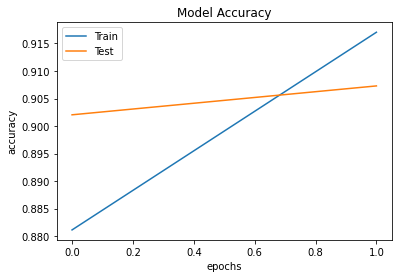

In [ ]:
# plot akurasi dari model
plt.plot(model_history.history['accuracy'], label='train')
plt.plot(model_history.history['val_accuracy'], label='test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

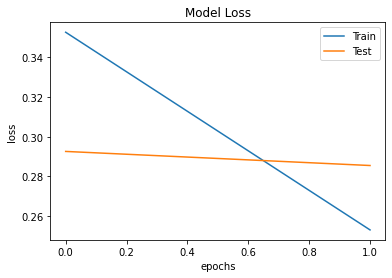

In [ ]:
# plot loss dari model

plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Kesimpulan:

Dari proses pembangunan model NLP di atas dapat disimpulkan bahwa model sesuai dengan dataset yang digunakan karena menunjukkan good fit (akurasi baik train maupun test lebih dari 90 dan tidak overfitting atau underfitting).

Hasil yang baik ini juga didukung oleh dataset yang rapih dan bersih sehingga membuat mesin mampu membaca pola dengan baik melalui model yang telah dibangun.